## Clip_implementation
The task is to train a multimodal model, i.e. a model that has inputs from various domains. Particulary, you're going to train CLIP model on a subset of [Flickr30k](https://www.kaggle.com/datasets/hsankesara/flickr-image-dataset) dataset. Flickr consists of images with different text descriptions (5 per each image), so by training the CLIP model with CNN as image encoder and some BERT as text encoder, you'll be able to match images with their descriptions.

We'll use some new for us packages:

- *timm* (Py**T**orch **Im**age **M**odels) - a collection of image models, layers, data-loaders etc. that aim to pull together Pytorch models with Huggingface interface.
- *albumentations* - package for advanced data augmentation.

In [7]:
!pip install timm
!pip install transformers

In [8]:
import os
import cv2
import numpy as np
import pandas as pd
import itertools
from tqdm import tqdm
import albumentations

import torch
from torch import nn
import torch.nn.functional as F
import timm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
np.random.seed(42)

In [9]:
# Path to .csv file with image captions in flickr
labels_path = "/kaggle/input/pmldl-week-13-multimodal-model/results_train.csv"
# Path to folder with images
image_path = "/kaggle/input/pmldl-week-13-multimodal-model/flickr10k_train/flickr10k_train"

In [10]:
# Each image in dataset has 5 captions
# id columns stands for a each image
df = pd.read_csv(labels_path)
df.head(20)

image  caption_number  \
0   1000268201.jpg               0   
1   1000268201.jpg               1   
2   1000268201.jpg               2   
3   1000268201.jpg               3   
4   1000268201.jpg               4   
5   1000523639.jpg               0   
6   1000523639.jpg               1   
7   1000523639.jpg               2   
8   1000523639.jpg               3   
9   1000523639.jpg               4   
10  1000919630.jpg               0   
11  1000919630.jpg               1   
12  1000919630.jpg               2   
13  1000919630.jpg               3   
14  1000919630.jpg               4   
15  1001896054.jpg               0   
16  1001896054.jpg               1   
17  1001896054.jpg               2   
18  1001896054.jpg               3   
19  1001896054.jpg               4   

                                              caption  id  
0   A child in a pink dress is climbing up a set o...   0  
1   A little girl in a pink dress going into a woo...   0  
2   A little girl climbing the stairs to her playh...   0  
3     A little girl climbing into a wooden playhouse    0  
4               A girl going into a wooden building .   0  
5   Two people in the photo are playing the guitar...   1  
6   A man in green holds a guitar while the other ...   1  
7        A man is fixing the guitar players costume .   1  
8            a guy stitching up another man 's coat .   1  
9                         the two boys playing guitar   1  
10  A man sits in a chair while holding a large st...   2  
11  A man is sitting on a chair holding a large st...   2  
12  A man completes the finishing touches on a stu...   2  
13             A man holds a large stuffed lion toy .   2  
14                 A man is smiling at a stuffed lion   2  
15  A man with reflective safety clothes and ear p...   3  
16  John Deere tractors cruises down a street , wh...   3  
17  A man in a neon green and orange uniform is dr...   3  
18  A man in a tractor wearing headphones driving ...   3  
19  A man driving a John Deere tractor on a main r...   3

## 1. Dataset

Define a structure of dataset for convenient working both with images and descriptions from Flickr

In [53]:
# Data augmentation
def get_transforms(mode="train"):
    img_size = 224
    if mode == "train":
        return albumentations.Compose(
            [
                # You can add additional augmentations
                albumentations.Resize(img_size, img_size, always_apply=True),
                albumentations.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )
    else:
        return albumentations.Compose(
            [
                albumentations.Resize(img_size, img_size, always_apply=True),
                albumentations.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )

# # Data augmentation
# def get_transforms(mode="train"):
#     img_size = 224
#     if mode == "train":
#         return albumentations.Compose(
#             [
#                 albumentations.Resize(img_size, img_size, always_apply=True),
#                 # Add random augmentations for training
#                 albumentations.HorizontalFlip(p=0.5),
#                 albumentations.VerticalFlip(p=0.5),
#                 albumentations.RandomBrightnessContrast(p=0.2),
#                 # albumentations.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.3),
#                 # albumentations.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, p=0.5),
#                 # albumentations.CoarseDropout(max_holes=8, max_height=16, max_width=16, min_holes=1, min_height=4, min_width=4, p=0.3),
#                 albumentations.Normalize(max_pixel_value=255.0, always_apply=True),
#             ]
#         )
#     else:
#         return albumentations.Compose(
#             [
#                 albumentations.Resize(img_size, img_size, always_apply=True),
#                 albumentations.Normalize(max_pixel_value=255.0, always_apply=True),
#             ]
#         )
        

# Load and formate the image that stores by img_path
# with transform app_transforms (one of the get_transforms() augmentations)
def preprocess_image(img_path, app_transforms):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = app_transforms(image=image)['image']
    return torch.tensor(image).permute(2, 0, 1).float()

class FlickrDataset(torch.utils.data.Dataset):
    # image_filenames - pd.Series with path to images 
    # captions - pd.Series with descriptions of the images
    def __init__(self, image_filenames, captions, tokenizer, transforms):
        self.image_filenames = image_filenames
        self.captions = list(captions)
        self.encoded_captions = tokenizer(list(captions), padding=True, truncation=True, max_length=200)
        self.transforms = transforms

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }
        
        item['image'] = preprocess_image(f"{image_path}/{self.image_filenames[idx]}", self.transforms)
        item['caption'] = self.captions[idx]
        return item
        
    def __len__(self):
        return len(self.captions)

### 2.1 Image encoder

*timm* allows to treat CNNs like transformers from HuggingFace. For example, *timm.create_model()* loads a model named by the first string parameter in the function, in the way as *transformers.AutoModel()*. While the authors of original CLIP didn't utilize pretrain weight, we'll load both CNN and BERT models due to lack of data and computation time.

**Choose some CNN you prefer**

In [54]:
import torch.nn as nn
import timm

class ImageEncoder(nn.Module):
    def __init__(self, model_name="resnet50"):
        super().__init__()
        # Load a pre-trained model from the timm library with no classification head
        self.model = timm.create_model(model_name, pretrained=True, num_classes=0, global_pool="avg")
        
        # Enable gradient computation for all parameters
        for p in self.model.parameters():
            p.requires_grad = True

    def forward(self, x):
        # Return the feature vector (penultimate layer activations)
        return self.model(x)


### 2.2 Text encoder

**Choose some BERT you prefer**

In [55]:
from transformers import AutoModel, AutoTokenizer
class TextEncoder(nn.Module):
    def __init__(self, model_name="distilbert-base-uncased"):
        super().__init__()
        self.model = AutoModel.from_pretrained(model_name)
        for p in self.model.parameters():
            p.requires_grad = True
        # Use the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

### 2.3 Projection head

After the encoders do their job, you should apply a nonlinear projection on the embeddings. By that, you get text and image embeddings in the same dimension space

In [56]:
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=256,
        dropout=0.1
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)
    
    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

### 2.5 Combine everything into a  CLIP model

Calculate loss in CLIP by the following pseudocode:
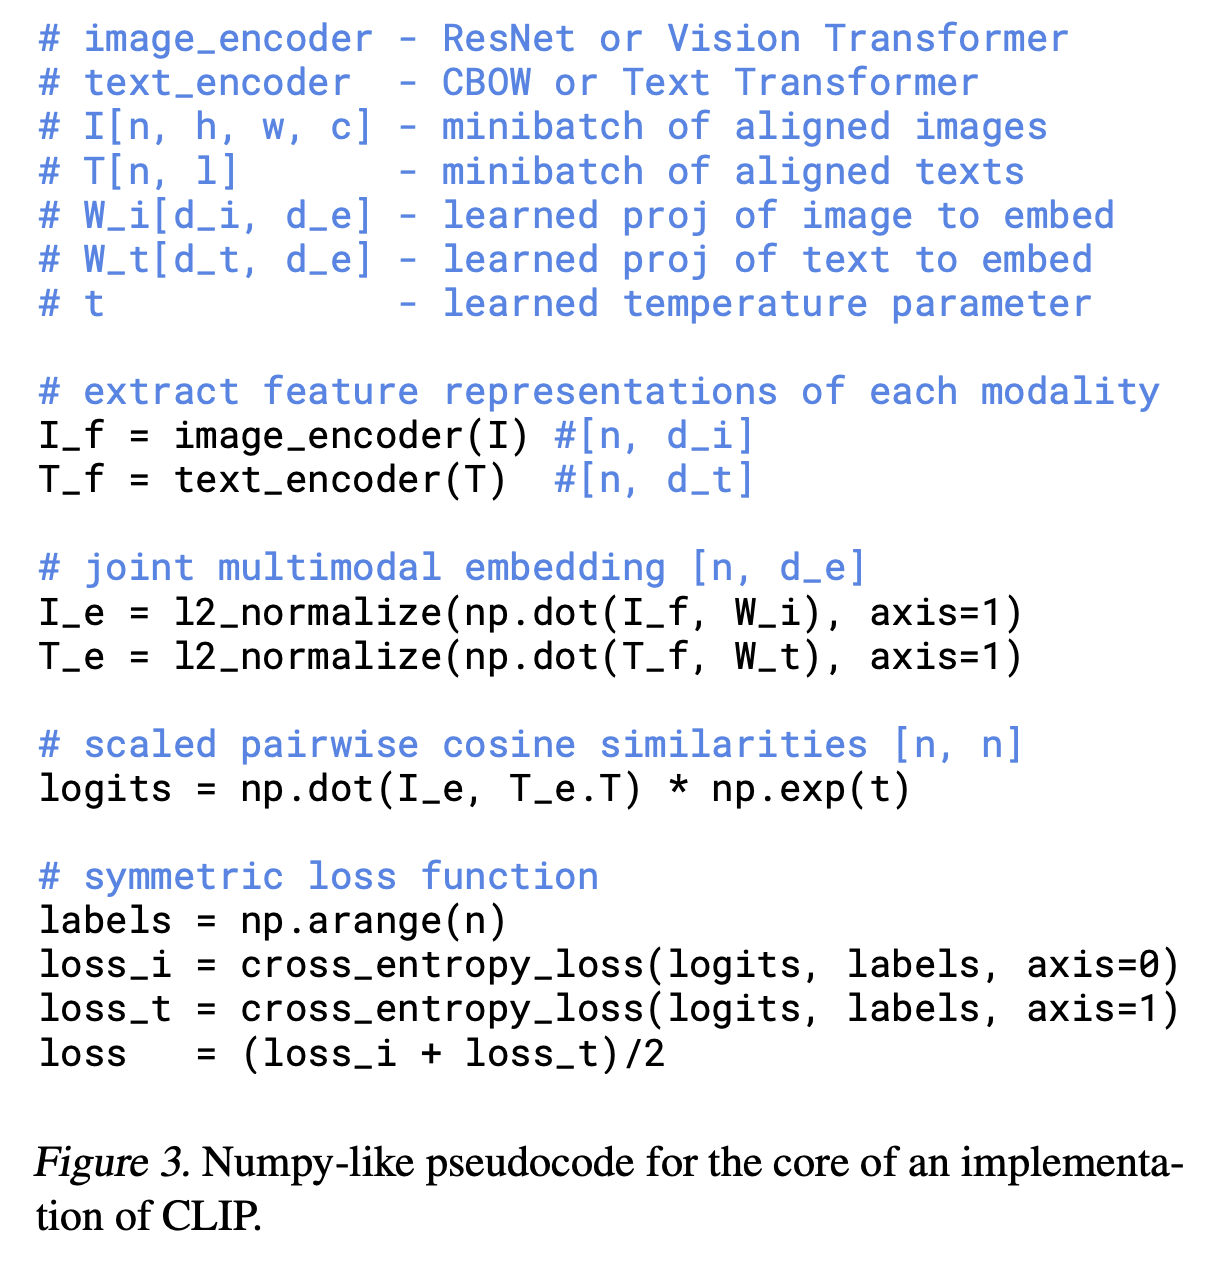

You don't need to use numpy,
Please refer to the [paper](https://arxiv.org/abs/2103.00020) for more information

In [57]:
# class CLIP(nn.Module):
#     def __init__(
#         self,
#         image_model_name,
#         text_model_name,
#         temperature=1.0,
#         image_embedding=2048,
#         text_embedding=768,
#     ):
#         super().__init__()
#         self.image_encoder = ImageEncoder(model_name=image_model_name)
#         self.text_encoder = TextEncoder(model_name=text_model_name)
#         self.image_projection = ProjectionHead(embedding_dim=image_embedding)
#         self.text_projection = ProjectionHead(embedding_dim=text_embedding)
#         self.temperature = nn.Parameter(torch.tensor(temperature))


#     def forward(self, batch):
#         # Getting Image and Text Features
#         image_features = self.image_encoder(batch["image"])  # [n, d_i]
#         text_features = self.text_encoder(
#             input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
#         )  # [n, d_t]
        
#         # Getting Image and Text Embeddings (with the same dimension)
#         image_embeddings = F.normalize(self.image_projection(image_features), p=2, dim=1)  # [n, d_e]
#         text_embeddings = F.normalize(self.text_projection(text_features), p=2, dim=1)  # [n, d_e]
        
#         # Calculating pairwise cosine similarities
#         logits_per_image = torch.matmul(image_embeddings, text_embeddings.T) * torch.exp(self.temperature)  # [n, n]
#         logits_per_text = logits_per_image.T  # [n, n]
        
#         # Symmetric loss function
#         batch_size = image_embeddings.shape[0]
#         labels = torch.arange(batch_size, device=logits_per_image.device)  # [0, 1, ..., n-1]
        
#         images_loss = F.cross_entropy(logits_per_image, labels)
#         texts_loss = F.cross_entropy(logits_per_text, labels)
#         loss = (images_loss + texts_loss) / 2.0
            
#         return loss



# def cross_entropy(preds, targets, reduction='none'):
#     log_softmax = nn.LogSoftmax(dim=-1)
#     loss = (-targets * log_softmax(preds)).sum(1)
#     if reduction == "none":
#         return loss
#     elif reduction == "mean":
#         return loss.mean()


# # class CLIP(nn.Module):
# #     def __init__(
# #         self,
# #         image_model_name,
# #         text_model_name,
# #         temperature=1.0,
# #         image_embedding=2048,
# #         text_embedding=768,
# #     ):
# #         super().__init__()
# #         self.image_encoder = ImageEncoder(model_name=image_model_name)
# #         self.text_encoder = TextEncoder(model_name=text_model_name)
# #         self.image_projection = ProjectionHead(embedding_dim=image_embedding)
# #         self.text_projection = ProjectionHead(embedding_dim=text_embedding)
# #         self.temperature = nn.Parameter(torch.tensor(temperature))

# #     def forward(self, batch):
# #         # Getting Image and Text Features
# #         image_features = self.image_encoder(batch["image"])  # (batch_size, image_embedding)
# #         text_features = self.text_encoder(
# #             input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
# #         )  # (batch_size, text_embedding)
        
# #         # Getting Image and Text Embeddings (with same dimension)
# #         image_embeddings = self.image_projection(image_features)  # (batch_size, projection_dim)
# #         text_embeddings = self.text_projection(text_features)  # (batch_size, projection_dim)
        
# #         # Normalize embeddings to unit vectors
# #         image_embeddings = F.normalize(image_embeddings, p=2, dim=-1)
# #         text_embeddings = F.normalize(text_embeddings, p=2, dim=-1)
        
# #         # Compute similarity scores
# #         logits_per_image = torch.matmul(image_embeddings, text_embeddings.T)  # (batch_size, batch_size)
# #         logits_per_text = logits_per_image.T  # Symmetric similarity matrix
        
# #         # Scale logits by temperature
# #         logits_per_image = logits_per_image / self.temperature
# #         logits_per_text = logits_per_text / self.temperature
        
# #         # Create ground truth (diagonal should be 1, rest should be 0)
# #         batch_size = image_embeddings.size(0)
# #         targets = torch.eye(batch_size, device=image_embeddings.device)
        
# #         # Calculate cross-entropy loss
# #         images_loss = cross_entropy(logits_per_image, targets, reduction="mean")
# #         texts_loss = cross_entropy(logits_per_text, targets, reduction="mean")
# #         loss = (images_loss + texts_loss) / 2.0
        
# #         return loss

# # def cross_entropy(preds, targets, reduction='none'):
# #     log_softmax = nn.LogSoftmax(dim=-1)
# #     loss = (-targets * log_softmax(preds)).sum(1)
# #     if reduction == "none":
# #         return loss
# #     elif reduction == "mean":
# #         return loss.mean()


class CLIP(nn.Module):
    def __init__(
        self,
        image_model_name,
        text_model_name,
        temperature=1.0,
        image_embedding=2048,
        text_embedding=768,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder(model_name=image_model_name)
        self.text_encoder = TextEncoder(model_name=text_model_name)
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = nn.Parameter(torch.tensor(temperature))

    def forward(self, batch):
        # Getting Image and Text Features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        # Getting Image and Text Embeddings (with same dimension)
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        # Normalize embeddings
        # image_embeddings = F.normalize(image_embeddings, p=2, dim=-1)
        # text_embeddings = F.normalize(text_embeddings, p=2, dim=-1)

        # Calculate similarity scores
        logits_per_image = torch.matmul(image_embeddings, text_embeddings.T) / self.temperature
        logits_per_text = logits_per_image.T

        # Ground truth labels
        batch_size = image_embeddings.size(0)
        targets = torch.eye(batch_size, device=image_embeddings.device)

        # Symmetric loss function
        images_loss = cross_entropy(logits_per_image, targets, reduction="mean")
        texts_loss = cross_entropy(logits_per_text, targets, reduction="mean")
        loss = (images_loss + texts_loss) / 2.0
        return loss


def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

## 3. Training

### 3.1 Define some training functions

In [58]:
def build_loaders(dataframe, tokenizer, mode):
    transform = get_transforms(mode=mode)
    dataset = FlickrDataset(
        dataframe["image"].values,
        dataframe["caption"].values,
        tokenizer=tokenizer,
        transforms=transform,
    )
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=32,
        num_workers=4,
        shuffle=True if mode == "train" else False,
    )
    return dataloader

In [59]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]


def train_epoch(model, train_loader, optimizer):
    model.train()
    
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    for batch in tqdm_object:
        batch = {k: v.to(device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        tqdm_object.set_postfix(train_loss=loss.item(), lr=get_lr(optimizer))


def valid_epoch(model, valid_loader):
    model.eval()

    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for batch in tqdm_object:
        batch = {k: v.to(device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)
        tqdm_object.set_postfix(valid_loss=loss.item())

### 3.2 Hyperparameters setting and train&validation split

In [62]:
head_lr = 1e-3
image_encoder_lr = 1e-4
text_encoder_lr = 1e-5
weight_decay = 1e-3
epochs = 3

In [63]:
max_id = df['id'].max() + 1
image_ids = np.arange(0, max_id)

valid_ids = np.random.choice(image_ids, size=int(0.2 * len(image_ids)), replace=False)
train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
train_df = df[df["id"].isin(train_ids)].reset_index(drop=True)
valid_df = df[df["id"].isin(valid_ids)].reset_index(drop=True)

### 3.3 Running train

In [64]:
# Write your code 
text_model = "bert-base-uncased"  # BERT model for text encoding
image_model = "resnet50"  # Vision Transformer for image encoding

tokenizer = AutoTokenizer.from_pretrained(text_model)
train_loader = build_loaders(train_df, tokenizer, mode="train")
valid_loader = build_loaders(valid_df, tokenizer, mode="valid")


model = CLIP(text_model_name=text_model, image_model_name=image_model).to(device)
# model = CLIP(
#     text_model_name=text_model,
#     image_model_name=image_model,
#     image_embedding=768,  # Corrected from 2048 to 768
#     text_embedding=768,
# ).to(device)
params = [
    {"params": model.image_encoder.parameters(), "lr": image_encoder_lr},
    {"params": model.text_encoder.parameters(), "lr": text_encoder_lr},
    {"params": itertools.chain(model.image_projection.parameters(), 
                               model.text_projection.parameters()), 
                            "lr": head_lr, "weight_decay": weight_decay}
]
optimizer = torch.optim.AdamW(params)


for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    train_epoch(model, train_loader, optimizer)
    with torch.no_grad():
        valid_epoch(model, valid_loader)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Epoch 1/3


  0%|          | 0/1250 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(tr

Epoch 2/3


  0%|          | 0/1250 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(tr

Epoch 3/3


  0%|          | 0/1250 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(tr

## 4. Submission

We measure the quality of the CLIP model by its ability to match text descriptions with images. In test dataset, you're given **labels.csv** file with the descriptions (in the same manner as in train set), and folder with images.

You need to calculate embeddings of both images and descriptions, measure cosine similarity between embeddings and return top 7 image file names per each description. Note that every five desctiptions correspond to one image, and a nice trained model returns about the same range of images for such descriptions. 

When doing competition evaluation, for each image we take best Reciprocal Rank (RR) alongside its five desctiption. For example, you need to retrive an image with name **cor_img.jpg** and have the predictions:

1. [wrong_img1.jpg, wrong_img2.jpg, wrong_img3.jpg,  *cor_img.jpg*, wrong_img4.jpg, wrong_img5.jpg, wrong_img6.jpg]
2. [wrong_img3.jpg, wrong_img1.jpg, wrong_img12.jpg,  wrong_img5.jpg, *cor_img.jpg*, wrong_img6.jpg, wrong_img10.jpg]
3. [**cor_img.jpg**, wrong_img2.jpg, wrong_img20.jpg, wrong_img6.jpg, wrong_img4.jpg, wrong_img1.jpg, wrong_img10.jpg]
4. [wrong_img2.jpg, wrong_img1.jpg, wrong_img12.jpg,  *cor_img.jpg*, wrong_img10.jpg, wrong_img5.jpg, wrong_img6.jpg]
5. [wrong_img1.jpg, wrong_img2.jpg, wrong_img3.jpg,  wrong_img10.jpg, wrong_img4.jpg, wrong_img5.jpg, wrong_img6.jpg]

For the 3rd desctiption, **cor_img.jpg** stays at the top, thus we consider RR for this sample as 1.

In [81]:

torch.save(model.state_dict(), "/kaggle/working/model3.pth")
import os
import torch
from torch.nn.functional import cosine_similarity
def get_test_filepath():
    test_path = "/kaggle/input/pmldl-week-13-multimodal-model/flickr10k_test/flickr10k_test"    
    file_paths = []
    for filename in os.listdir(test_path):
        f = os.path.join(test_path, filename)
        if '.jpg' in f:
            file_paths.append(f)
    return file_paths

def get_test_embeddings(model, file_paths):
    valid_image_embeddings = []
    transform = get_transforms(mode='valid')
    with torch.no_grad():
        for file_path in tqdm(file_paths):
            image_features = model.image_encoder(preprocess_image(file_path, transform).unsqueeze(0).to(device))
            image_embeddings = model.image_projection(image_features)
            valid_image_embeddings.append(image_embeddings)
    return torch.cat(valid_image_embeddings)


# def find_matches(model, image_embeddings,tokenizer, query, image_filenames, n):
#     encoded_query = tokenizer([query])
#     batch = {
#         key: torch.tensor(values).to(device)
#         for key, values in encoded_query.items()
#     }
#     with torch.no_grad():
#         text_features = model.text_encoder(
#             input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
#         )
#         text_embeddings = model.text_projection(text_features)
#     # Write your code here
#     # Compute cosine similarity and return top n file names
#     ...
#     # Indices stands for top n indices in similarity vector
#     matches = [image_filenames[idx].split("/")[-1] for idx in indices]
#     return matches


# import torch.nn.functional as F

# def find_matches(model, image_embeddings, tokenizer, query, image_filenames, n):
#     # Encode the query into text embeddings
#     encoded_query = tokenizer([query])
#     batch = {
#         key: torch.tensor(values).to(device)
#         for key, values in encoded_query.items()
#     }
#     with torch.no_grad():
#         text_features = model.text_encoder(
#             input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
#         )
#         text_embeddings = model.text_projection(text_features)
#         text_embeddings = F.normalize(text_embeddings, p=2, dim=-1)  # Normalize embeddings

#     # Normalize image embeddings
#     image_embeddings = F.normalize(image_embeddings, p=2, dim=-1)

#     # Compute cosine similarity between query and image embeddings
#     similarities = torch.matmul(text_embeddings, image_embeddings.T).squeeze(0)

#     # Get indices of the top `n` matches
#     top_indices = torch.topk(similarities, k=n).indices

#     # Get the corresponding file names
#     matches = [image_filenames[idx].split("/")[-1] for idx in top_indices]
#     return matches

# def find_matches(model, image_embeddings, tokenizer, query, image_filenames, n):
#     # Tokenize the query
#     encoded_query = tokenizer([query])
#     batch = {
#         key: torch.tensor(values).to(device)
#         for key, values in encoded_query.items()
#     }

#     # Get text embeddings
#     with torch.no_grad():
#         text_features = model.text_encoder(
#             input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
#         )
#         text_embeddings = model.text_projection(text_features)

#     # Compute cosine similarity and return top n file names
#     similarities = cosine_similarity(text_embeddings, image_embeddings, dim=-1)
#     top_n_indices = torch.topk(similarities, n, dim=-1).indices.squeeze(0)

#     # Get top n matching filenames
#     matches = [image_filenames[idx].split("/")[-1] for idx in top_n_indices]
#     return matches

import os

def get_test_filepath():
    test_path = "/kaggle/input/pmldl-week-13-multimodal-model/flickr10k_test/flickr10k_test"    
    file_paths = []
    for filename in os.listdir(test_path):
        f = os.path.join(test_path, filename)
        if '.jpg' in f:
            file_paths.append(f)
    return file_paths

def get_test_embeddings(model, file_paths):
    valid_image_embeddings = []
    transform = get_transforms(mode='valid')
    with torch.no_grad():
        for file_path in tqdm(file_paths):
            image_features = model.image_encoder(preprocess_image(file_path, transform).unsqueeze(0).to(device))
            image_embeddings = model.image_projection(image_features)
            valid_image_embeddings.append(image_embeddings)
    return torch.cat(valid_image_embeddings)

from torch.nn.functional import cosine_similarity
import torch.nn.functional as F

def find_matches(model, image_embeddings, tokenizer, query, image_filenames, n):
    # Tokenize the query
    encoded_query = tokenizer([query], padding=True, truncation=True, return_tensors="pt")
    batch = {
        key: values.to(device)
        for key, values in encoded_query.items()
    }

    # Generate text embeddings
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)
        text_embeddings = F.normalize(text_embeddings, p=2, dim=-1)  # Normalize the embeddings

    # Compute cosine similarity
    image_embeddings = F.normalize(image_embeddings, p=2, dim=-1)  # Normalize image embeddings
    similarity = torch.matmul(text_embeddings, image_embeddings.T).squeeze(0)

    # Get top `n` indices
    _, indices = torch.topk(similarity, n)

    # Map indices to file names
    matches = [image_filenames[idx].split("/")[-1] for idx in indices]
    return matches


Epoch 1/3


  0%|          | 0/1250 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(tr

KeyboardInterrupt: 

In [76]:
test_df = pd.read_csv("/kaggle/input/pmldl-week-13-multimodal-model/labels.csv")

In [77]:
file_paths = get_test_filepath()
image_embeddings = get_test_embeddings(model, file_paths)

100%|██████████| 200/200 [00:02<00:00, 85.77it/s]


In [78]:
submission_df = pd.DataFrame(columns=['ID', *(range(7))])
submission_df['image_id'] = test_df.id
submission_df['ID'] = test_df.index

for ind, row in test_df.iterrows(): 
    predicted_path = find_matches(model, image_embeddings, tokenizer, 
                                  row['caption'],file_paths, 7)
    for i in range(7):
        submission_df.at[ind, i] = predicted_path[i]
    

In [79]:
# Some samples from my solution
submission_df.head(20)

ID               0               1               2               3  \
0    0   116457850.jpg  4808471657.jpg  3341628972.jpg  1891462514.jpg   
1    1   116457850.jpg  4808471657.jpg   570996053.jpg  3341628972.jpg   
2    2  4808471657.jpg   116457850.jpg   550119995.jpg     4515460.jpg   
3    3   116457850.jpg  4808471657.jpg  1891462514.jpg  2889346148.jpg   
4    4   116457850.jpg  4808471657.jpg  4800121810.jpg   570996053.jpg   
5    5   123101580.jpg  3545652636.jpg  2894217628.jpg   241346352.jpg   
6    6  3545652636.jpg   123101580.jpg  2894217628.jpg   241346352.jpg   
7    7  3545652636.jpg   123101580.jpg  2894217628.jpg   241346352.jpg   
8    8   123101580.jpg  3545652636.jpg   241346352.jpg  2894217628.jpg   
9    9  2894217628.jpg   123101580.jpg   241346352.jpg  3545652636.jpg   
10  10  3069837790.jpg  4955130534.jpg  1303157527.jpg  3371224046.jpg   
11  11  2441818043.jpg  3565840872.jpg   280007961.jpg  3259222980.jpg   
12  12  3069837790.jpg    74306574.jpg  1303157527.jpg   450746926.jpg   
13  13  3069837790.jpg   450746926.jpg  3565840872.jpg  3621972977.jpg   
14  14  1303157527.jpg  4955130534.jpg    19810652.jpg  4406616207.jpg   
15  15  2936693681.jpg  2423856014.jpg  1307635496.jpg  2408224709.jpg   
16  16  2423856014.jpg  2936693681.jpg  1307635496.jpg  2725042940.jpg   
17  17  2936693681.jpg  2423856014.jpg  2408224709.jpg   753285176.jpg   
18  18  2936693681.jpg  2423856014.jpg  1307635496.jpg  2408224709.jpg   
19  19  2936693681.jpg  2423856014.jpg   753285176.jpg  2408224709.jpg   

                 4               5               6  image_id  
0    570996053.jpg  2889346148.jpg  4800121810.jpg         0  
1   1891462514.jpg  2889346148.jpg  4800121810.jpg         0  
2   4480560554.jpg  2422637172.jpg  2981162237.jpg         0  
3    570996053.jpg  4800121810.jpg   550119995.jpg         0  
4   3341628972.jpg  1891462514.jpg   753285176.jpg         0  
5   5662260935.jpg  6950137939.jpg  3679341667.jpg         1  
6   5662260935.jpg  6950137939.jpg  3679341667.jpg         1  
7   6950137939.jpg  5662260935.jpg  3679341667.jpg         1  
8   5662260935.jpg  6950137939.jpg  3679341667.jpg         1  
9   6950137939.jpg  5662260935.jpg  3679341667.jpg         1  
10   280007961.jpg  3565840872.jpg  3621972977.jpg         2  
11  2468058000.jpg  3069837790.jpg  3371224046.jpg         2  
12  4955130534.jpg  3621972977.jpg  3371224046.jpg         2  
13  1303157527.jpg  4690243307.jpg    19810652.jpg         2  
14  3922716352.jpg  4480560554.jpg  3069837790.jpg         2  
15   753285176.jpg  2725042940.jpg  4986937036.jpg         3  
16  3155601377.jpg  2408224709.jpg   753285176.jpg         3  
17  1307635496.jpg  3341628972.jpg  4986937036.jpg         3  
18  2725042940.jpg   753285176.jpg  4986937036.jpg         3  
19  1307635496.jpg  3341628972.jpg   570996053.jpg         3

In [80]:
submission_df.to_csv("submission.csv", index=False)

In [72]:
# seconddf = submission_df.copy()

In [73]:
# import pandas as pd

# # Load CSV files
# df1 = submission_df
# df2 = seconddf

# # Check exact equality
# if df1.equals(df2):
#     print("The two files are identical.")
# else:
#     print("The two files have differences.")


The two files have differences.
